In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Conv1D, Lambda, Add, Multiply, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import random
import pickle
import glob
from tqdm import tqdm
import os

from python_speech_features import mfcc
import scipy.io.wavfile as wav
import librosa
from IPython.display import Audio

import csv

In [2]:
with open('./train-toneless_update.csv', newline='', errors='ignore') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
        if row[0] != 'id':
            a=row[0]
            b=row[1].lower()
            f=open('./train/txt/' + a + '.txt', 'w')
            f.write(b)
            f.close()

In [3]:
def get_wav_files(wav_path):
    wav_files = []
    for (dirpath, dirname, filenames) in os.walk(wav_path):
        for filename in filenames:
            if filename.endswith('.wav') or filename.endswith('.WAV'):
                filename_path = os.path.join(dirpath, filename)
                wav_files.append(filename_path)
    return wav_files

def get_tran_texts(wav_files, tran_path):
    tran_texts = []
    for wav_file in wav_files:
        basename = os.path.basename(wav_file)
        x = os.path.splitext(basename)[0]
        tran_file = os.path.join(tran_path, x+'.txt')
        if os.path.exists(tran_file) is False:
            return None
        fd = open(tran_file, 'r')
        text = fd.readline()
        tran_texts.append(text.split('\n')[0])
        fd.close()
    return tran_texts

In [4]:
paths = get_wav_files('./train')
texts = get_tran_texts(paths, './train/txt')

In [5]:
print(texts[0])
print(paths[0])

li be e mih kiann lan lan san san long be tsiau tsng
./train\1.wav


Audio Text: li be e mih kiann lan lan san san long be tsiau tsng


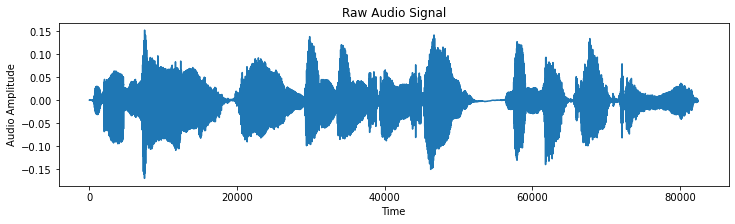

Shape of MFCC: (372, 13)


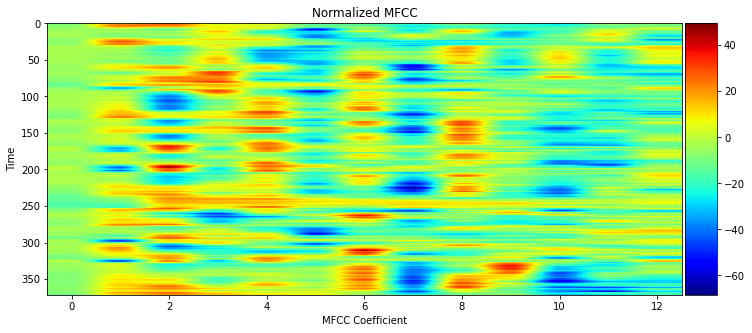

In [6]:
mfcc_dim = 13

def load_and_trim(path):
    audio, sr = librosa.load(path)
    energy = librosa.feature.rms(audio)
    frames = np.nonzero(energy >= np.max(energy)/10)
    indices = librosa.core.frames_to_samples(frames)[1]
    audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
    
    return audio, sr

def visualize(index):
    path = paths[index]
    text = texts[index]
    print('Audio Text:', text)
    
    audio, sr = load_and_trim(path)
    plt.figure(figsize=(12, 3))
    plt.plot(np.arange(len(audio)), audio)
    plt.title('Raw Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Audio Amplitude')
    plt.show()
    
    feature = mfcc(audio, sr, numcep=mfcc_dim, nfft=551)
    print('Shape of MFCC:', feature.shape)
    
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    im = ax.imshow(feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    plt.colorbar(im, cax=make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05))
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()
    
    return path

Audio(visualize(0))

In [7]:
total = len(paths)
features = []
for i in tqdm(range(total)):
    path = paths[i]
    audio, sr = load_and_trim(path)
    features.append(mfcc(audio, sr, numcep=mfcc_dim, nfft=551))
    
print(len(features), features[0].shape)

100%|█████████████████████████████████████████████████████████████████████████████| 3119/3119 [00:27<00:00, 112.22it/s]

3119 (372, 13)


In [8]:
samples = random.sample(features, 100)
samples = np.vstack(samples)

mfcc_mean = np.mean(samples, axis=0)
mfcc_std = np.std(samples, axis=0)
print(mfcc_mean)
print(mfcc_std)

features = [(feature - mfcc_mean) / (mfcc_std + 1e-14) for feature in features]

[ -5.80443707  -4.79731573  -4.5531159    0.27538827  -2.39205075
 -16.04881795   3.44168858 -10.52570925  -7.50949627  -5.28158521
 -13.12141672  -9.07578589  -7.51346357]
[ 3.71413239 16.54460794 19.44495968 19.14499536 15.53972029 18.09278308
 14.4818599  15.23020839 15.10518582 13.5124139  14.0171025  11.77752958
 12.09882697]


In [9]:
chars = {}
for text in texts:
    text = text.lower()
    for c in text:
        chars[c] = chars.get(c, 0) + 1

chars = sorted(chars.items(), key=lambda x: x[1], reverse=True)
chars = [char[0] for char in chars]
print(len(chars), chars[:100])

char2id = {c: i for i, c in enumerate(chars)}
id2char = {i: c for i, c in enumerate(chars)}
print(char2id)

27 [' ', 'i', 'a', 'n', 't', 'h', 's', 'u', 'o', 'k', 'g', 'e', 'l', 'p', 'b', 'm', 'j', 'r', 'c', 'd', 'f', 'y', 'v', 'w', 'x', 'q', 'z']
{' ': 0, 'i': 1, 'a': 2, 'n': 3, 't': 4, 'h': 5, 's': 6, 'u': 7, 'o': 8, 'k': 9, 'g': 10, 'e': 11, 'l': 12, 'p': 13, 'b': 14, 'm': 15, 'j': 16, 'r': 17, 'c': 18, 'd': 19, 'f': 20, 'y': 21, 'v': 22, 'w': 23, 'x': 24, 'q': 25, 'z': 26}


In [10]:
data_index = np.arange(total)
np.random.shuffle(data_index)
train_size = int(0.9 * total)
test_size = total - train_size
train_index = data_index[:train_size]
test_index = data_index[train_size:]

X_train = [features[i] for i in train_index]
Y_train = [texts[i] for i in train_index]
X_test = [features[i] for i in test_index]
Y_test = [texts[i] for i in test_index]

batch_size = 4

def batch_generator(x, y, batch_size=batch_size):  
    offset = 0
    while True:
        offset += batch_size
        
        if offset == batch_size or offset >= len(x):
            data_index = np.arange(len(x))
            np.random.shuffle(data_index)
            x = [x[i] for i in data_index]
            y = [y[i] for i in data_index]
            offset = batch_size
            
        X_data = x[offset - batch_size: offset]
        Y_data = y[offset - batch_size: offset]
        
        X_maxlen = max([X_data[i].shape[0] for i in range(batch_size)])
        Y_maxlen = max([len(Y_data[i]) for i in range(batch_size)])
        
        X_batch = np.zeros([batch_size, X_maxlen, mfcc_dim])
        Y_batch = np.ones([batch_size, Y_maxlen]) * len(char2id)
        X_length = np.zeros([batch_size, 1], dtype='int32')
        Y_length = np.zeros([batch_size, 1], dtype='int32')
        for i in range(batch_size):
            X_length[i, 0] = X_data[i].shape[0]
            X_batch[i, :X_length[i, 0], :] = X_data[i]
            
            Y_length[i, 0] = len(Y_data[i])
            Y_batch[i, :Y_length[i, 0]] = [char2id[c] for c in Y_data[i]]
            
        inputs = {'X': X_batch, 'Y': Y_batch, 'X_length': X_length, 'Y_length': Y_length}
        outputs = {'ctc': np.zeros([batch_size])}
        yield (inputs, outputs)

In [11]:
epochs = 30
num_blocks = 3
filters = 128

X = Input(shape=(None, mfcc_dim,), dtype='float32', name='X')
Y = Input(shape=(None,), dtype='float32', name='Y')
X_length = Input(shape=(1,), dtype='int32', name='X_length')
Y_length = Input(shape=(1,), dtype='int32', name='Y_length')

def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)(inputs)

def batchnorm(inputs):
    return BatchNormalization()(inputs)

def activation(inputs, activation):
    return Activation(activation)(inputs)

def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'tanh')
    hg = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'sigmoid')
    h0 = Multiply()([hf, hg])
    
    ha = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    hs = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    
    return Add()([ha, inputs]), hs

h0 = activation(batchnorm(conv1d(X, filters, 1, 1)), 'tanh')
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 1, 1)), 'relu')
Y_pred = activation(batchnorm(conv1d(h1, len(char2id) + 1, 1, 1)), 'softmax')
sub_model = Model(inputs=X, outputs=Y_pred)

def calc_ctc_loss(args):
    y, yp, ypl, yl = args
    return K.ctc_batch_cost(y, yp, ypl, yl)

ctc_loss = Lambda(calc_ctc_loss, output_shape=(1,), name='ctc')([Y, Y_pred, X_length, Y_length])
model = Model(inputs=[X, Y, X_length, Y_length], outputs=ctc_loss)
optimizer =SGD(lr=0.002, momentum=0.9, nesterov=True, clipnorm=5)
model.compile(loss={'ctc': lambda ctc_true, ctc_pred: ctc_pred}, optimizer=optimizer)

checkpointer = ModelCheckpoint(filepath='asr.h5', verbose=0)
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000)

history = model.fit_generator(
    generator=batch_generator(X_train, Y_train), 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs, 
    validation_data=batch_generator(X_test, Y_test), 
    validation_steps=len(X_test) // batch_size, 
    callbacks=[checkpointer, lr_decay])

C:\Users\kevin\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\kevin\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
701/701 [==============================] - 296s 395ms/step - loss: 91.0501 - val_loss: 46.4396


C:\Users\kevin\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
701/701 [==============================] - 157s 224ms/step - loss: 38.5712 - val_loss: 36.5956
Epoch 3/30
701/701 [==============================] - 157s 224ms/step - loss: 32.6027 - val_loss: 34.0278
Epoch 4/30
701/701 [==============================] - 151s 216ms/step - loss: 28.2660 - val_loss: 29.3235
Epoch 5/30
701/701 [==============================] - 146s 208ms/step - loss: 24.7848 - val_loss: 31.8900
Epoch 6/30
701/701 [==============================] - 148s 211ms/step - loss: 22.1205 - val_loss: 30.0372
Epoch 7/30
701/701 [==============================] - 147s 210ms/step - loss: 19.6573 - val_loss: 29.9890
Epoch 8/30
701/701 [==============================] - 149s 212ms/step - loss: 17.9607 - val_loss: 32.5385
Epoch 9/30
701/701 [==============================] - 146s 209ms/step - loss: 16.3520 - val_loss: 37.3348
Epoch 10/30
701/701 [==============================] - 147s 210ms/step - loss: 15.1306 - val_loss: 30.9781
Epoch 11/30
701/701 [========================

In [12]:
sub_model.save('asr.h5')
with open('dictionary.pkl', 'wb') as fw:
    pickle.dump([char2id, id2char, mfcc_mean, mfcc_std], fw)

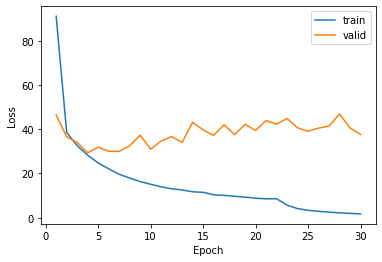

In [13]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(np.linspace(1, epochs, epochs), train_loss, label='train')
plt.plot(np.linspace(1, epochs, epochs), valid_loss, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [14]:
from keras.models import load_model
import pickle

with open('dictionary.pkl', 'rb') as fr:
    [char2id, id2char, mfcc_mean, mfcc_std] = pickle.load(fr)

sub_model = load_model('asr.h5')

def random_predict(x, y):
    index = np.random.randint(len(x))
    feature = x[index]
    text = y[index]
    
    pred = sub_model.predict(np.expand_dims(feature, axis=0))
    pred_ids = K.eval(K.ctc_decode(pred, [feature.shape[0]], greedy=False, beam_width=10, top_paths=1)[0][0])
    pred_ids = pred_ids.flatten().tolist()
    pred_ids_2 = []
    
    a = ['']*(len(pred_ids))
    z = 0
    
    for i in pred_ids:
        if (i != -1):
            a[z] = id2char[i]
            print(id2char[i], end = '')
            z = z+1
        else :
            break
    while '' in a:
        a.remove('')
    print(a)
   
    pred_ids_2.append(a)
    
    print(pred_ids_2)
    print('True transcription:\n-- ', text, '\n')
    print('Predicted transcription:\n-- ' +''.join([id2char[i] for i in range(len(pred_ids_2))]), '\n')

random_predict(X_train, Y_train)
random_predict(X_test, Y_test)



ui sian mih be tang an ne['u', 'i', ' ', 's', 'i', 'a', 'n', ' ', 'm', 'i', 'h', ' ', 'b', 'e', ' ', 't', 'a', 'n', 'g', ' ', 'a', 'n', ' ', 'n', 'e']
[['u', 'i', ' ', 's', 'i', 'a', 'n', ' ', 'm', 'i', 'h', ' ', 'b', 'e', ' ', 't', 'a', 'n', 'g', ' ', 'a', 'n', ' ', 'n', 'e']]
True transcription:
--  ui siann mih be tang an ne 

Predicted transcription:
--   

kuan thai lang tshui tshiun beh lau tiam to tsit ping ['k', 'u', 'a', 'n', ' ', 't', 'h', 'a', 'i', ' ', 'l', 'a', 'n', 'g', ' ', 't', 's', 'h', 'u', 'i', ' ', 't', 's', 'h', 'i', 'u', 'n', ' ', 'b', 'e', 'h', ' ', 'l', 'a', 'u', ' ', 't', 'i', 'a', 'm', ' ', 't', 'o', ' ', 't', 's', 'i', 't', ' ', 'p', 'i', 'n', 'g', ' ']
[['k', 'u', 'a', 'n', ' ', 't', 'h', 'a', 'i', ' ', 'l', 'a', 'n', 'g', ' ', 't', 's', 'h', 'u', 'i', ' ', 't', 's', 'h', 'i', 'u', 'n', ' ', 'b', 'e', 'h', ' ', 'l', 'a', 'u', ' ', 't', 'i', 'a', 'm', ' ', 't', 'o', ' ', 't', 's', 'i', 't', ' ', 'p', 'i', 'n', 'g', ' ']]
True transcription:
--  kuan thai lang

In [15]:
from keras.models import load_model
from keras import backend as K
import numpy as np
import librosa
from python_speech_features import mfcc
import pickle
import glob

wavs = glob.glob('./test-shuf/*.wav')
with open('dictionary.pkl', 'rb') as fr:
    [char2id, id2char, mfcc_mean, mfcc_std] = pickle.load(fr)

mfcc_dim = 13
model = load_model('asr.h5')

index = np.random.randint(len(wavs))
print(wavs[index])

audio, sr = librosa.load(wavs[index])
energy = librosa.feature.rms(audio)
frames = np.nonzero(energy >= np.max(energy) / 10)
indices = librosa.core.frames_to_samples(frames)[1]
audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
X_data = mfcc(audio, sr, numcep=mfcc_dim, nfft=551)
X_data = (X_data - mfcc_mean) / (mfcc_std + 1e-14)
print(X_data.shape)

'''with open(wavs[index] + '.txt', 'r', encoding='utf8') as fr:
    label = fr.readlines()[0]
    print(label)'''

pred = model.predict(np.expand_dims(X_data, axis=0))
pred_ids = K.eval(K.ctc_decode(pred, [X_data.shape[0]], greedy=False, beam_width=10, top_paths=1)[0][0])
pred_ids = pred_ids.flatten().tolist()
pred_ids_2 = []
    
a = ['']*(len(pred_ids))
z = 0
    
for i in pred_ids:
    if (i != -1):
        a[z] = id2char[i]
        print(id2char[i], end = '')
        z = z+1
    else :
        break
while '' in a:
        a.remove('')
print(a)
   
pred_ids_2.append(a)
print(''.join([id2char[i] for i in range(len(pred_ids_2))]))

./test-shuf\120.wav
(761, 13)
i ui tiok hio bang ne king lean kong ong po tshuan kah sih bing kui si tha tsit tshut tai uan lag hi beh tua ki phin tdan hian['i', ' ', 'u', 'i', ' ', 't', 'i', 'o', 'k', ' ', 'h', 'i', 'o', ' ', 'b', 'a', 'n', 'g', ' ', 'n', 'e', ' ', 'k', 'i', 'n', 'g', ' ', 'l', 'e', 'a', 'n', ' ', 'k', 'o', 'n', 'g', ' ', 'o', 'n', 'g', ' ', 'p', 'o', ' ', 't', 's', 'h', 'u', 'a', 'n', ' ', 'k', 'a', 'h', ' ', 's', 'i', 'h', ' ', 'b', 'i', 'n', 'g', ' ', 'k', 'u', 'i', ' ', 's', 'i', ' ', 't', 'h', 'a', ' ', 't', 's', 'i', 't', ' ', 't', 's', 'h', 'u', 't', ' ', 't', 'a', 'i', ' ', 'u', 'a', 'n', ' ', 'l', 'a', 'g', ' ', 'h', 'i', ' ', 'b', 'e', 'h', ' ', 't', 'u', 'a', ' ', 'k', 'i', ' ', 'p', 'h', 'i', 'n', ' ', 't', 'd', 'a', 'n', ' ', 'h', 'i', 'a', 'n']
 


In [16]:
from keras.models import load_model
from keras import backend as K
import numpy as np
import librosa
from python_speech_features import mfcc
import pickle
import glob

wavs = glob.glob('./test-shuf/*.wav')
with open('dictionary.pkl', 'rb') as fr:
    [char2id, id2char, mfcc_mean, mfcc_std] = pickle.load(fr)

mfcc_dim = 13
model = load_model('asr.h5')

In [17]:
text_path = []
for i in range(346):
    text_path.append('./test-shuf/'+str(i+1)+'.wav')

result = []
for wavs in text_path:
    audio, sr = librosa.load(wavs)
    energy = librosa.feature.rms(audio)
    frames = np.nonzero(energy >= np.max(energy) / 10)
    indices = librosa.core.frames_to_samples(frames)[1]
    audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
    X_data = mfcc(audio, sr, numcep=mfcc_dim, nfft=551)
    X_data = (X_data - mfcc_mean) / (mfcc_std + 1e-14)
    pred = model.predict(np.expand_dims(X_data, axis=0))
    pred_ids = K.eval(K.ctc_decode(pred, [X_data.shape[0]], greedy=False, beam_width=10, top_paths=1)[0][0])
    pred_ids = pred_ids.flatten().tolist()
    
    #pred_ids_2 = []
    
    a = ['']*(len(pred_ids))
    z = 0
    
    for i in pred_ids:
        if (i != -1):
            a[z] = id2char[i]
            print(id2char[i], end = '')
            z = z+1
        else :
            break
    while '' in a:
        a.remove('')
    
   
    result.append(a)
    
    '''Y = ''.join([id2char[i] for i in range(len(result))])
    print(Y)
    result.append(Y)'''
result

tse ho tsan sie kai bing pang ka tik li khuan tsai gan lai u pu li e ing honWARNING:tensorflow:5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001C996992310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
ing am gua tsiah kah li liean loWARNING:tensorflow:6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001C996992310> triggered tf.func

ah beh sian posi si giam po soa sui kam mo a pa tsok li the i tshing kaan ne lalin kiam bo kong iau u si gie jit tsiu siu kua e si kau ma gua ka lin kong giah bak khuan hngit king sik thang kua laha san a pa me kue ahkiam pian tsiah ka khan khan kisan sih siu o ho ki ki khuti hiah khuan e lang iah si sam sam gong o tshin tshin tsng tsngthonh lai lai lai thai si tsia thai sio tsiahi tsing li tai gi su lui tsog si te si tua kang tingma su iau siong se uiueli tsit e ho ne metui putin lai kong tse tai piau i kiong ngie tui khong bi kok ka au tsiu tit tioh sing lithing loh lai e si sim lai kam u buan tsiok e kam kak sing khu na kian liau siun kihong bun ao to bai si tsian ping siong e kau thong kang khu tsuan tai uan tshue boh lang be hiau khia oa to bai kah hit tsam pi tsit tsun jit tsi ke lua hing ho leling gua pun si giam tshai iong kan vua e su bui kan tan hun tua lui tong su mia su hing iong su ting tinglau hian ti a puan lo ta puan lo khi ah lin thang tua se sianm na si lan hian tai t

gu a li khuan leh tsiok sui tsiok ko tsuie iun tsogng ne lag be ti tsit su lah tsau in a ki tui p le tu lai tsan seh i tsit kui kang liam mi hua kuain liamg mi hua lua koh e si tioh ma la li aui tsit e kak to khuan tsu tong gi su tah phue thong ke pio tui su tian su tiau e siu lok e tang the kiong tsit kuan kian gilan sit pai kui beh pue bong li tshia gua bon ng pai to huan hue ahkhu na e bo kuan apeh khi li khuan naiiau kiu kha ho e sia hue tsing tshikgua kong li tsit e ko mng kau ah gun toa leh ka li kong ue li tsit ma si sian thaie to aa pah ai pha au pai m kanin e put ban koh ka lai tsu san tsiah e tsng kha e pun buan hue ha tui sia hun un ting tso sing thiau tssin tik tshi tsit ui go hue tsap po tin a in ui ui tng iampiak tshut tua tng phah khang king kue kin kip beh tshiu sut tsiah kue bin li tshiu lik khit lai sun suan ka li pong hui ahoi e phue hu p pe pti tiak lun tok tsia kong ok bama e iu tiam si i tsu tiong su iong king tse ka gua kau e link liong li khuan mui tsu u tsiah k

m bian bua hiap pnoh msat bak a tu liau kau tshi i gua koh u sian mih tik sili ka sing ua e tiong sim khng ti to ui bo tai tsi thang tso e si li kam e khang hi tsit e lang e sitsit uan tho tau khn khong ka mi mi mi tsian ho lo ago tiam ji e n vi an su tsotsit uan png ling linghngh m tsian niaso ni tshiuk ki a kam u ho iongie sai tsioh tsin ah si be satsit e u thian sim a i koh kah in ting se sing khu tsit pai phak ta liau au the ut ta ka u ka tshiun sin e kang khuan tsing tsha sit tsui u khah sim thang tsha ili sian mih si tsun beh tng khi tai pathian kong gin a lang kho u a khah gau tuoatng lai ahsin lun te tshian kai sue tsoak tsia so kong lu sing m si tshut si to tsian tso lu sing si hong kau iok tso u sing e tsit ku e i ham tsap hun bian koh pian han kah ni te li tsin to han gua lahsian mih lang kong li ou tshin bap khuan e si eh ah li tsiah kau kai mia lah ah lim pe ko te tsioh a kau lahbo jin ho e kuan htshn pa lah si gun a kong khah tsa siong ai khuan e hiti le ko tsai si tsun p

[['t',
  's',
  'e',
  ' ',
  'h',
  'o',
  ' ',
  't',
  's',
  'a',
  'n',
  ' ',
  's',
  'i',
  'e',
  ' ',
  'k',
  'a',
  'i',
  ' ',
  'b',
  'i',
  'n',
  'g',
  ' ',
  'p',
  'a',
  'n',
  'g',
  ' ',
  'k',
  'a',
  ' ',
  't',
  'i',
  'k',
  ' ',
  'l',
  'i',
  ' ',
  'k',
  'h',
  'u',
  'a',
  'n',
  ' ',
  't',
  's',
  'a',
  'i',
  ' ',
  'g',
  'a',
  'n',
  ' ',
  'l',
  'a',
  'i',
  ' ',
  'u',
  ' ',
  'p',
  'u',
  ' ',
  'l',
  'i',
  ' ',
  'e',
  ' ',
  'i',
  'n',
  'g',
  ' ',
  'h',
  'o',
  'n'],
 ['i',
  'n',
  'g',
  ' ',
  'a',
  'm',
  ' ',
  'g',
  'u',
  'a',
  ' ',
  't',
  's',
  'i',
  'a',
  'h',
  ' ',
  'k',
  'a',
  'h',
  ' ',
  'l',
  'i',
  ' ',
  'l',
  'i',
  'e',
  'a',
  'n',
  ' ',
  'l',
  'o'],
 ['a', 'h', ' ', 'b', 'e', 'h', ' ', 's', 'i', 'a', 'n', ' ', 'p', 'o'],
 ['s',
  'i',
  ' ',
  's',
  'i',
  ' ',
  'g',
  'i',
  'a',
  'm',
  ' ',
  'p',
  'o',
  ' ',
  's',
  'o'],
 ['a',
  ' ',
  's',
  'u',
  'i',
  ' ',
  'k',
  'a',


In [18]:
print("".join(result[10]))

ti hiah khuan e lang iah si sam sam gong o tshin tshin tsng tsng


In [19]:
import csv
with open('output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    
    writer.writerow(['id', 'text'])
    for i in range(346):
        writer.writerow([i+1,"".join(result[i])])